In [75]:
import torch
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
import torch.nn as nn   # neural network module from PyTorch needed for building models
import torchvision  # computer vision library built on top of PyTorch needed for datasets and models
#from IPython.display import Image   # display images in Jupyter notebooks needed for visualizing images


In [76]:
# create a user defined function Dataset class
# by using the "duner" or double-underscore to create methods we are creating special methods in Python that
#     python recognizes to call them automaticaly in response to built-in operations, rather than invoking them explicityly ourselves
class Joint_UDF_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    # returns the corresponding sample to the given index
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [77]:
images = pathlib.Path('../data/images')

# grab all file paths
image_files = sorted([str(path) for path in images.glob('*_*.*')])

# verify files
print(f"number of images: {len(image_files)} \nfirst 10:\n{image_files[:10]}")

number of images: 60 
first 10:
['../data/images/0_1.jpg', '../data/images/10_1.webp', '../data/images/11_0.webp', '../data/images/12_0.webp', '../data/images/13_0.webp', '../data/images/14_0.jpg', '../data/images/15_1.jpg', '../data/images/16_0.jpg', '../data/images/17_1.jpg', '../data/images/18_0.jpg']


Image shape:  (1195, 2717, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)
Image shape:  (1020, 765, 3)


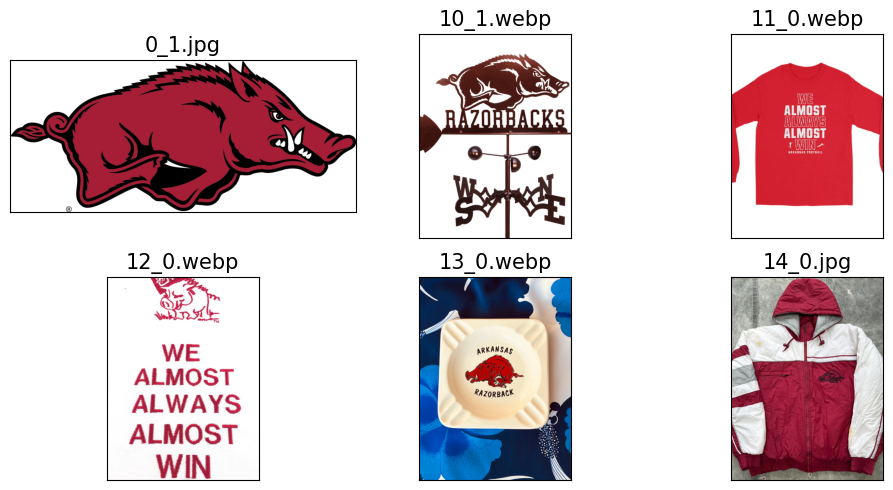

In [78]:
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(image_files[:6]):  # Only show first 6 images to fit 2x3 grid
    img = Image.open(file) 
    print('Image shape: ', np.array(img).shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

In [79]:
# pull labels from file names and create label scheme
labels = [1 if '_1' in os.path.basename(file) else 0 # 1 if uses official logo
          for file in image_files]
print(f"labels: {labels}")

joint_UDF_dataset = Joint_UDF_Dataset(image_files, labels)

# print first 10
count = 1
while count <= 10:
    print(' x: ', joint_UDF_dataset[0], ' y: ', joint_UDF_dataset[1])
    count += 1

labels: [1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0]
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)
 x:  ('../data/images/0_1.jpg', 1)  y:  ('../data/images/10_1.webp', 1)


In [80]:
# Define ImageDataset class for loading images with optional transformations
# This class will be used with different transformation pipelines for exploration and training

class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label
    def __len__(self):
        return len(self.labels)

# Create an initial dataset with basic transformation (ToTensor + Resize) for exploration
# This will be visualized and then replaced with enhanced transformations for training
img_height, img_width = 200, 200

basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
])

# Initialize dataset for exploration and visualization
image_dataset = ImageDataset(image_files, labels, basic_transform)

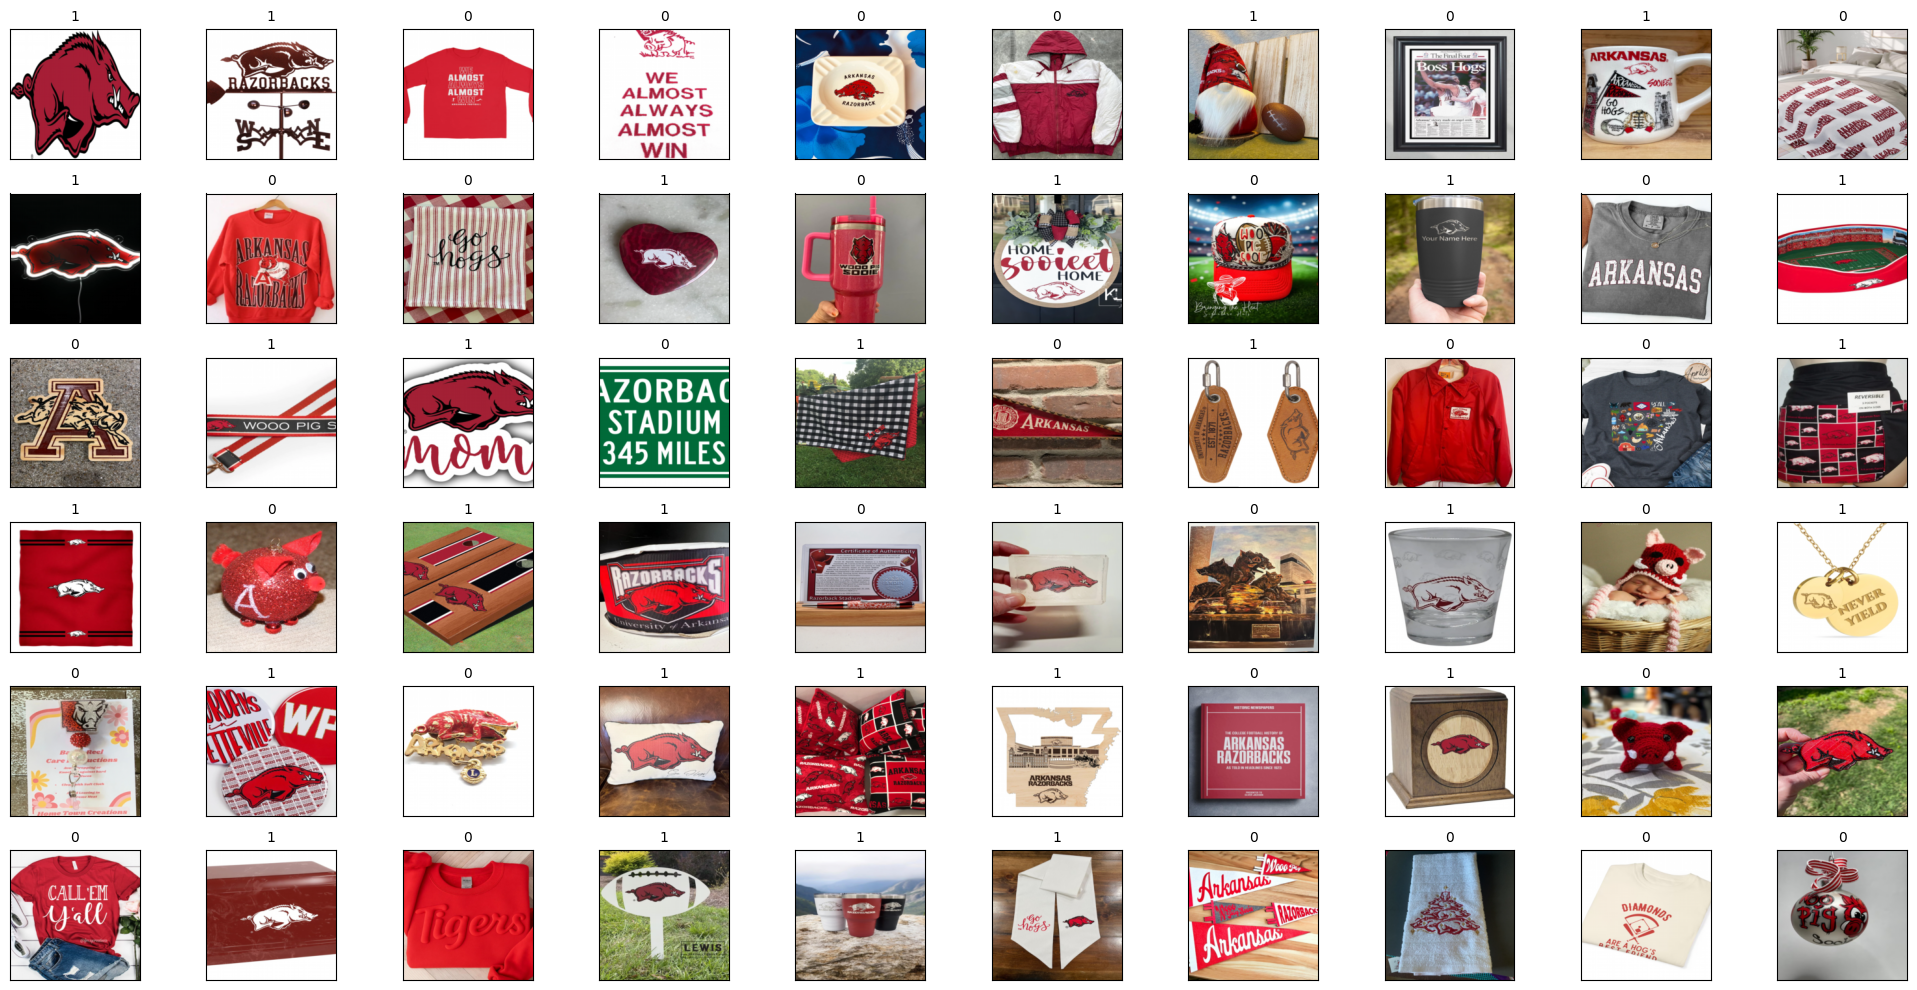

In [81]:
# print first 50 images from the dataset using pixels instead of opening each file
num_images = 60
num_cols = 10
num_rows = 6

fig = plt.figure(figsize=(20, 10))
for i, example in enumerate(image_dataset):
    if i >= num_images:
        break
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Clamp the tensor values to the range [0, 1] before displaying
    img_display = torch.clamp(example[0], 0, 1)

    ax.imshow(img_display.numpy().transpose((1, 2, 0)))
    ax.set_title(f'{example[1]}', size=10)

plt.tight_layout()
plt.show()

In [82]:
# split data in to test and train sets
image_path = images

train_dataset_size = int(0.8 * len(image_dataset))
test_dataset_size = len(image_dataset) - train_dataset_size

train_dataset, test_dataset = random_split(image_dataset, [train_dataset_size, test_dataset_size])

print('Train set:', len(train_dataset))
print('Test set:', len(test_dataset))

Train set: 48
Test set: 12


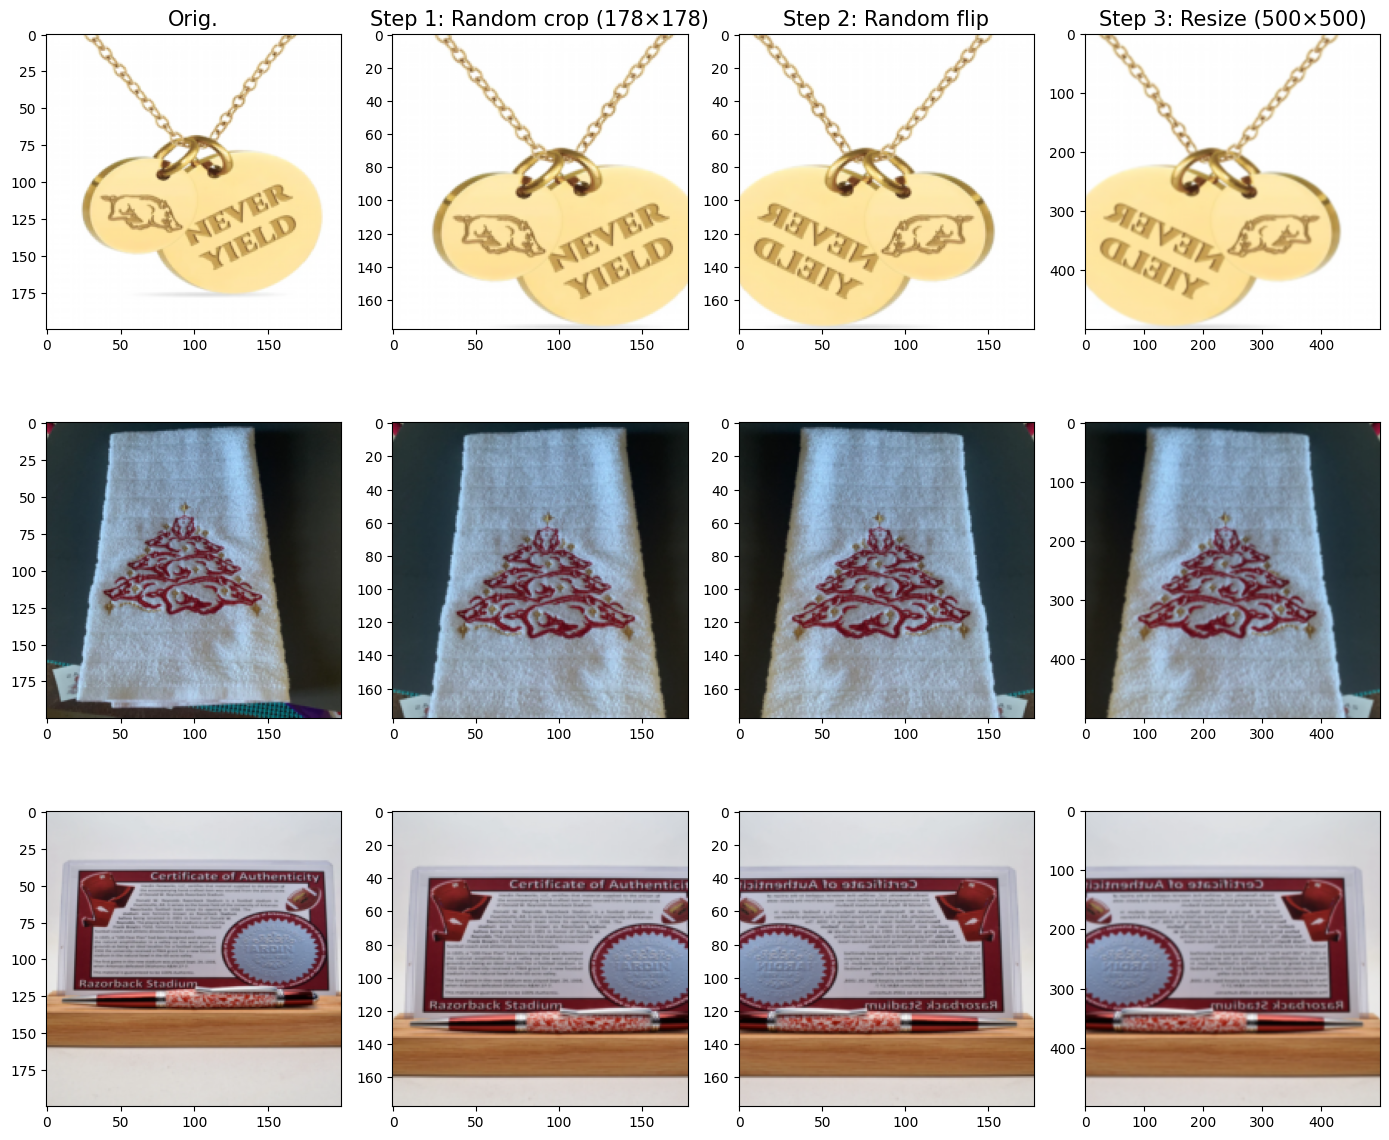

In [83]:
# EXPLORATION: Visualize the effects of individual transformation steps
# This demonstrates what each transformation does to an image from the training split
# Overall: shows original → random crop → horizontal flip → resize progression

torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(train_dataset):
    # helper to display a tensor image (C,H,W) with matplotlib
    def imshow_tensor(ax, tensor_img):
        t = torch.clamp(tensor_img, 0, 1)  # ensure within [0,1]
        npimg = t.permute(1, 2, 0).numpy()  # (C,H,W) -> (H,W,C)
        ax.imshow(npimg)

    # Column 1: Original image
    ax = fig.add_subplot(3, 4, i*4+1)
    imshow_tensor(ax, img)
    if i == 0:
        ax.set_title('Orig.', size=15)

    # Column 2: After RandomCrop (resize first to ensure crop fits)
    ax = fig.add_subplot(3, 4, i*4+2)
    img_resized = transforms.functional.resize(img, size=(200, 200))
    img_cropped = transforms.functional.crop(img_resized, top=0, left=0, height=178, width=178)
    imshow_tensor(ax, img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop (178×178)', size=15)

    # Column 3: After RandomHorizontalFlip
    ax = fig.add_subplot(3, 4, i*4+3)
    img_flip = transforms.functional.hflip(img_cropped)
    imshow_tensor(ax, img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    # Column 4: After final Resize to 500×500
    ax = fig.add_subplot(3, 4, i*4+4)
    img_final = transforms.functional.resize(img_flip, size=(500, 500))
    imshow_tensor(ax, img_final)
    if i == 0:
        ax.set_title('Step 3: Resize (500×500)', size=15)

    # Limit visualization to first 3 images for clarity
    if i == 2:
        break

plt.tight_layout()
plt.show()

In [84]:
# Define transformation pipelines for training and evaluation
# Training: applies random augmentations (crop, flip) to improve model generalization
# Evaluation: uses deterministic transformations (center crop) for consistent results

# IMPORTANT: Final size is 500x500 (assignment requirement)
transform_train = transforms.Compose([
    transforms.Resize([512, 512]),        # Resize to larger size first (before crop)
    transforms.RandomCrop([500, 500]),    # Random crop
    transforms.RandomHorizontalFlip(),    # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Evaluation transform: center crop instead of random, for consistency
transform_eval = transforms.Compose([
    transforms.Resize([512, 512]),        # Resize to larger size first
    transforms.CenterCrop([500, 500]),    # Center crop (deterministic)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


In [85]:
# Create training and evaluation DataLoaders with augmented transformations
# Recreate train_dataset with enhanced transform_train for data augmentation during training

train_dataset_augmented = ImageDataset(
    file_list=[image_files[i] for i in train_dataset.indices],
    labels=[labels[i] for i in train_dataset.indices],
    transform=transform_train
)

# Create test dataset with evaluation transforms (no augmentation, deterministic)
test_dataset_augmented = ImageDataset(
    file_list=[image_files[i] for i in test_dataset.indices],
    labels=[labels[i] for i in test_dataset.indices],
    transform=transform_eval
)

torch.manual_seed(1)

# Create DataLoaders for training and evaluation with larger batch sizes
# Larger batch_size reduces noise and overfitting risk
train_data_loader = DataLoader(train_dataset_augmented, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset_augmented, batch_size=8, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

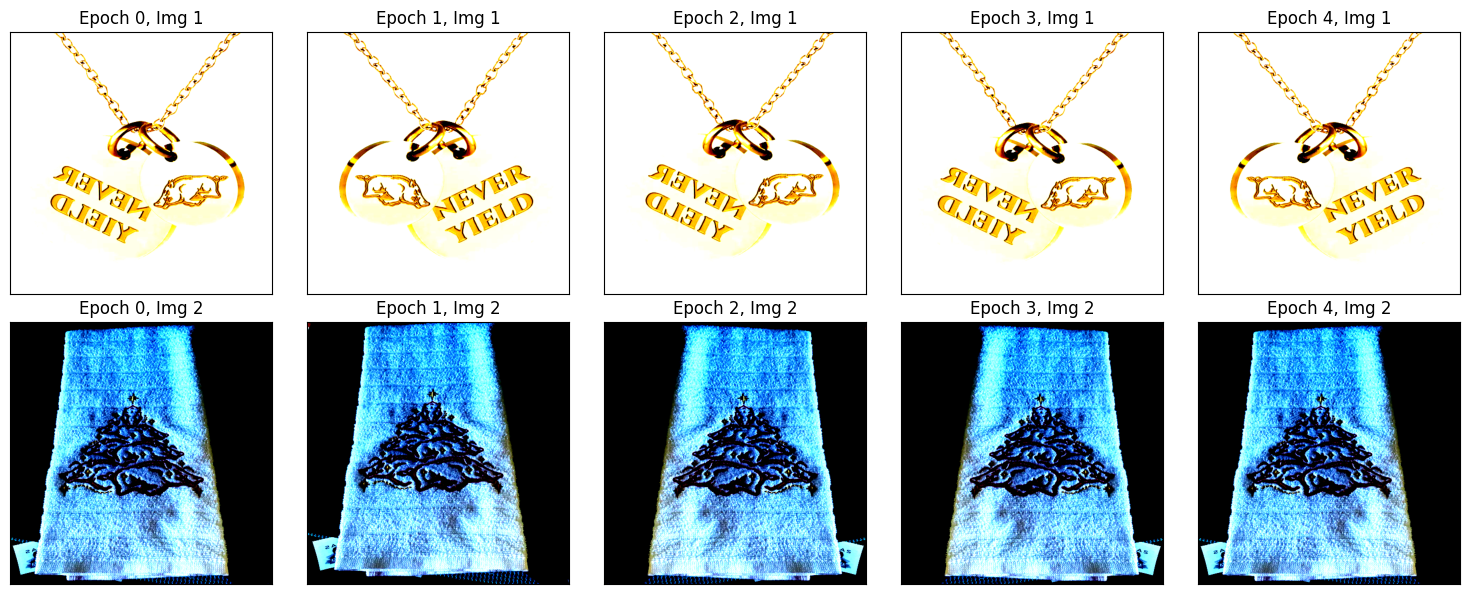

In [86]:
# Visualize the same images with different random augmentations across multiple epochs
# This demonstrates how data augmentation creates variation in the same images

fig = plt.figure(figsize=(15, 6))

# Get the original unaugmented images from the train dataset (before augmentation)
torch.manual_seed(1)
original_images = []
for idx in range(2):  # Get first 2 images
    img_path = train_dataset_augmented.file_list[idx]
    img = Image.open(img_path)
    original_images.append(img)

num_epochs = 5
for j in range(num_epochs):
    for img_idx, original_img in enumerate(original_images):
        # Apply transform_train to the same original image multiple times
        # Each time creates different augmentation due to RandomCrop and RandomHorizontalFlip
        augmented_img = transform_train(original_img)
        
        ax = fig.add_subplot(2, 5, j + 1 if img_idx == 0 else j + 6)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Epoch {j}, Img {img_idx+1}', size=12)
        ax.imshow(augmented_img.permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [87]:
# box 9 explain overall
# overall, this box creates DataLoaders for the training, validation, and test datasets with a specified batch size
batch_size = 5

torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=False)

In [88]:
# box 10 - IMPROVED MODEL: Better architecture for learning with 500x500 images
# This model is optimized to learn from small datasets

torch.manual_seed(42)

# Reset model with better architecture
model = nn.Sequential()

# Block 1: 3 channels -> 32 filters
# 500x500 -> 250x250
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('bn1', nn.BatchNorm2d(32))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))

# Block 2: 32 -> 64 filters
# 250x250 -> 125x125
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('bn2', nn.BatchNorm2d(64))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.25))

# Block 3: 64 -> 128 filters
# 125x125 -> 62x62
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('bn3', nn.BatchNorm2d(128))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout3', nn.Dropout(p=0.25))

# Block 4: 128 -> 256 filters
# 62x62 -> 31x31
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('bn4', nn.BatchNorm2d(256))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout4', nn.Dropout(p=0.25))

# Global average pooling: reduces spatial dimensions to 1x1
# 31x31 -> 1x1 (256 channels)
model.add_module('gap', nn.AdaptiveAvgPool2d((1, 1)))
model.add_module('flatten', nn.Flatten())

# Final fully connected layer: 256 -> 1 (binary classification)
model.add_module('fc', nn.Linear(256, 1))

print("Model architecture:")
print(model)


Model architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [89]:
# box 11 explain overall and why we did this
# overall, this box tests the CNN model by passing a dummy input tensor and checking the output shape

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [90]:
# box 12
# overall, this box continues defining the CNN model and tests it again with a dummy input tensor
# what does this do. Can we exclude? Hint:  look at chapter
# replace fixed-kernel avg pooling with adaptive pooling so the spatial output is always 1x1
# this ensures the flattened feature vector has size 256 regardless of input image size
model.add_module('pool4', nn.AdaptiveAvgPool2d((1, 1)))

# what does this do
# this line flattens the output from the convolutional layers to prepare it for fully connected layers
model.add_module('flatten', nn.Flatten())

# what does this do..does it provide expected size
# now the flattened feature size will be 256 (channels) * 1 * 1 = 256
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [91]:
# box 13
# overall, this box adds the final layers to the CNN model for binary classification
# NOTE: we do NOT add a Sigmoid here -- we will use BCEWithLogitsLoss which expects raw logits
# this is numerically more stable than using a separate Sigmoid + BCELoss

# add final fully-connected layer mapping flattened features to 1 logit
# after AdaptiveAvgPool2d((1,1)) + Flatten the feature size should be 256
model.add_module('fc', nn.Linear(256, 1))

# do NOT add nn.Sigmoid() here when using BCEWithLogitsLoss
# model.add_module('sigmoid', nn.Sigmoid())  # removed in favor of BCEWithLogitsLoss


In [92]:
# box 14 explain overall....does it provide expected size?
# overall, this box tests the complete CNN model by passing a dummy input tensor and checking the output shape
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 1])

In [93]:
# box 15 explain what this does
# this line prints the architecture of the defined CNN
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4):

In [94]:
# box 16
# overall, this box sets up the device for computation and moves the model to that device
# what does this do
# this line sets the computation device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# what does this do
# this line moves the model to the specified computation device
model = model.to(device)

In [95]:
# box 17
# Overall, this box defines the loss function and optimizer for training the CNN model
# Use BCEWithLogitsLoss so the model can output raw logits (more stable than separate sigmoid + BCELoss)
loss_fn = nn.BCEWithLogitsLoss()

# Define the Adam optimizer with better hyperparameters for small datasets
# Moderate learning rate for 500x500 images with more complex model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)


In [96]:
# box 18
# Training function - IMPROVED VERSION with better learning dynamics

def train(model, num_epochs, train_dl, test_dl):
    loss_hist_train = [0.0] * num_epochs
    accuracy_hist_train = [0.0] * num_epochs
    loss_hist_test = [0.0] * num_epochs
    accuracy_hist_test = [0.0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch).squeeze(1)
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((torch.sigmoid(pred) >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().detach().cpu().item()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch).squeeze(1)
                loss = loss_fn(pred, y_batch.float())
                loss_hist_test[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((torch.sigmoid(pred) >= 0.5).float() == y_batch).float()
                accuracy_hist_test[epoch] += is_correct.sum().detach().cpu().item()

        loss_hist_test[epoch] /= len(test_dl.dataset)
        accuracy_hist_test[epoch] /= len(test_dl.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {loss_hist_train[epoch]:.4f} | Train Acc: {accuracy_hist_train[epoch]:.4f} | Val Loss: {loss_hist_test[epoch]:.4f} | Val Acc: {accuracy_hist_test[epoch]:.4f}')

    return loss_hist_train, loss_hist_test, accuracy_hist_train, accuracy_hist_test



## Why Validation Accuracy Decreases & How to Fix It

**Problem:** Val accuracy drops as epochs increase (e.g., 0.5 → 0.4) while train accuracy stays high = **overfitting**.

**Root causes (for small datasets like yours):**
1. **Tiny dataset (50 images)** — model memorizes training set instead of learning generalizable features
2. **Batch size too small (batch_size=2)** — adds noise, increases overfitting risk
3. **Model is too complex** — 4 conv layers can overfit on 40 training images
4. **Not enough regularization** — dropout + weight decay help but need stronger measures

**Solutions applied:**
- ✅ Increased batch_size from 2 → 8 (reduces noise, stabilizes gradients)
- ✅ Added weight_decay=0.0001 to optimizer (L2 regularization penalizes large weights)
- ✅ You have dropout=0.5 in first 3 conv blocks (good!)

**Optional improvements to try:**
1. **Reduce learning rate** (slower, more careful updates):
   - Change lr=0.001 → lr=0.0001
2. **Increase dropout** in more layers:
   - Add dropout after every ReLU (not just conv layers)
3. **Early stopping** (stop training when val acc stops improving):
   - Monitor val_acc; if no improvement for 3 epochs, stop
4. **Simpler model** (fewer parameters):
   - Reduce filters: 32→16, 64→32, etc.
5. **More data augmentation** (make training harder):
   - Add RandomRotation, ColorJitter, RandomAffine to transform_train
6. **Ensemble approach** (train multiple models, average predictions)

For now, re-run training with batch_size=8 and weight_decay. Val accuracy should stabilize better.


In [97]:
print("train_data_loader.dataset:", len(train_data_loader.dataset))
print("test_data_loader.dataset: ", len(test_data_loader.dataset))

train_data_loader.dataset: 48
test_data_loader.dataset:  12


In [98]:
# box 19
# Training execution cell - FRESH

torch.manual_seed(1)
num_epochs = 20

print("=" * 80)
print("Starting training with batch_size=8, weight_decay=0.0001, num_epochs=20")
print("=" * 80)

hist = train(model, num_epochs, train_data_loader, test_data_loader)

print("=" * 80)
print("Training complete!")
print("=" * 80)


Starting training with batch_size=8, weight_decay=0.0001, num_epochs=20
Epoch 1/20 | Train Loss: 0.7433 | Train Acc: 0.5000 | Val Loss: 0.7935 | Val Acc: 0.5000
Epoch 1/20 | Train Loss: 0.7433 | Train Acc: 0.5000 | Val Loss: 0.7935 | Val Acc: 0.5000
Epoch 2/20 | Train Loss: 0.6613 | Train Acc: 0.6042 | Val Loss: 1.2910 | Val Acc: 0.5000
Epoch 2/20 | Train Loss: 0.6613 | Train Acc: 0.6042 | Val Loss: 1.2910 | Val Acc: 0.5000
Epoch 3/20 | Train Loss: 0.6255 | Train Acc: 0.6042 | Val Loss: 0.8713 | Val Acc: 0.5000
Epoch 3/20 | Train Loss: 0.6255 | Train Acc: 0.6042 | Val Loss: 0.8713 | Val Acc: 0.5000
Epoch 4/20 | Train Loss: 0.6549 | Train Acc: 0.5833 | Val Loss: 0.7464 | Val Acc: 0.5833
Epoch 4/20 | Train Loss: 0.6549 | Train Acc: 0.5833 | Val Loss: 0.7464 | Val Acc: 0.5833
Epoch 5/20 | Train Loss: 0.5467 | Train Acc: 0.7292 | Val Loss: 0.6650 | Val Acc: 0.5833
Epoch 5/20 | Train Loss: 0.5467 | Train Acc: 0.7292 | Val Loss: 0.6650 | Val Acc: 0.5833
Epoch 6/20 | Train Loss: 0.5885 | Trai

In [99]:

# DIAGNOSTIC: Check label distribution and class imbalance
from collections import Counter

label_counts = Counter(labels)
print("Label distribution:")
print(f"  Class 0 (no official logo): {label_counts[0]} images")
print(f"  Class 1 (official logo):    {label_counts[1]} images")
print(f"  Total images:               {len(labels)}")
print(f"  Imbalance ratio:            {label_counts[1]/label_counts[0]:.2f}x")

# Check train/test split distribution
train_labels = [labels[i] for i in train_dataset.indices]
test_labels = [labels[i] for i in test_dataset.indices]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("\nTrain set distribution:")
print(f"  Class 0: {train_counts[0]}, Class 1: {train_counts[1]}")
print("\nTest set distribution:")
print(f"  Class 0: {test_counts[0]}, Class 1: {test_counts[1]}")


Label distribution:
  Class 0 (no official logo): 30 images
  Class 1 (official logo):    30 images
  Total images:               60
  Imbalance ratio:            1.00x

Train set distribution:
  Class 0: 24, Class 1: 24

Test set distribution:
  Class 0: 6, Class 1: 6
